In [358]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

In [359]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PopMusicInformationRetrieval import gunshot_utils as utils
import importlib
import torch as th
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from pydub.playback import play
import numpy as np

importlib.reload(utils)

<module 'gunshot_utils' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/gunshot_utils.py'>

In [360]:
gunshot_df = pd.read_pickle('sampled_gunshot_metadata.pkl')
gunshot_df = gunshot_df[['filename', 'gunshot_location_in_seconds', 'num_gunshots']]
gunshot_df.head()

,filename,gunshot_location_in_seconds,num_gunshots
15,./selected_gunshots/glock_17_9mm(16).wav,[0.07517007],2
9,./selected_gunshots/glock_17_9mm(10).wav,[1.62344671],1
201,./selected_gunshots/glock_17_9mm(665).wav,[1.75],4
82,./selected_gunshots/glock_17_9mm(91).wav,[0.14414966],2
68,./selected_gunshots/glock_17_9mm(77).wav,[1.75],1


In [361]:
music_df = pd.read_pickle('sampled_music_metadata_44100.pkl')
music_df = music_df[['Path', 'Sample Rate (Hz)']]
music_df.head()

,Path,Sample Rate (Hz)
0,./selected_music/Stoned Raiders.wav,44100
1,./selected_music/Just Like Daddy.wav,44100
2,./selected_music/Blueberry.wav,44100
3,./selected_music/Little Girls.wav,44100
4,./selected_music/De La Soul - Fanatic of the B...,44100


In [362]:
music_train_df, music_valid_df = train_test_split(music_df, test_size=0.2, random_state=42)
gunshot_train_df, gunshot_valid_df = train_test_split(gunshot_df, test_size=0.2, random_state=42)

In [363]:
print("SHAPES:")
print(f"music_train_df: {music_train_df.shape}, music_valid_df: {music_valid_df.shape}")
print(f"gunshot_train_df: {gunshot_train_df.shape}, gunshot_valid_df: {gunshot_valid_df.shape}")

SHAPES:
music_train_df: (80, 2), music_valid_df: (20, 2)
gunshot_train_df: (80, 3), gunshot_valid_df: (20, 3)


In [364]:
class GunshotDetectionCNN(nn.Module):
    def __init__(self, num_frames):
        super(GunshotDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=(3, 7))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))

        dummy_input = th.zeros(1, 3, 80, num_frames)
        dummy_output = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(dummy_input))))))
        output_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(output_size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x)))  # Apply dropout
        x = self.sigmoid(self.fc2(x))
        return x

model = GunshotDetectionCNN(num_frames=utils.NUM_FRAMES)

In [365]:
music_metadata = utils.create_metadata_map('./selected_music')

In [366]:
class GunshotDataset(th.utils.data.Dataset):
    def __init__(self, music_df, gunshot_df, music_metadata, gunshot_prob=1.0, min_decibels=3, max_decibels=5, mean=None, std=None):
        super().__init__()
        self.music_paths = music_df['Path'].tolist()
        self.gunshot_paths = gunshot_df['filename'].tolist()
        self.gunshot_truth = gunshot_df['gunshot_location_in_seconds'].tolist()
        self.music_metadata = music_metadata
        self.gunshot_prob = gunshot_prob
        self.min_decibels = min_decibels
        self.max_decibels = max_decibels
        
    def __getitem__(self, idx):
        fn_music = self.music_paths[idx]
        fn_music_metadata = self.music_metadata[fn_music]
        music_waveform = utils.select_random_segment(file_path=fn_music,metadata=fn_music_metadata)
        
        add_gunshot = (np.random.rand() < self.gunshot_prob)
        if add_gunshot:
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths) - 1)
            fn_gunshot = self.gunshot_paths[gunshot_idx]
            gunshot_times = self.gunshot_truth[gunshot_idx][0]
            segment, sr = utils.combine_music_and_gunshot(music_waveform, fn_gunshot, gunshot_times, pre_gunshot_time=0.3)
            label = 1
        else:
            segment = music_waveform
            label = 0
            
        sepctograms, labels = utils.preprocess_audio_train(segment, label=label)
        
        if not sepctograms or not labels:
            raise ValueError("Spectrograms or labels are empty after preprocessing")

        return sepctograms[0], labels[0]

    def __len__(self):
        return len(self.music_paths)

In [367]:
train_dataset = GunshotDataset(music_train_df, gunshot_train_df, music_metadata, gunshot_prob=0.5)
valid_dataset = GunshotDataset(music_valid_df, gunshot_valid_df, music_metadata, gunshot_prob=0.5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [368]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
use_cuda = th.cuda.is_available()

mean, std = utils.compute_mean_std(train_loader)
mean = mean.to(device)
std = std.to(device)

Computing mean and std: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch [1/10] Training: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=0.694]


Epoch [1/10], Loss: 0.6846


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Validation ROC AUC: 1.0000
New best ROC AUC score: 1.0000, model saved.


Epoch [2/10] Training: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s, loss=0.635]


Epoch [2/10], Loss: 0.6532


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Validation ROC AUC: 0.9890


Epoch [3/10] Training: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s, loss=0.597]


Epoch [3/10], Loss: 0.6039


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Validation ROC AUC: 0.8929


Epoch [4/10] Training: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=0.52] 


Epoch [4/10], Loss: 0.5441


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Validation ROC AUC: 0.9600
No improvement in ROC AUC score for 3 epochs. Stopping training.


Finding Optimal Threshold: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Optimal threshold found: 0.5064


Computing Confusion Matrix: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


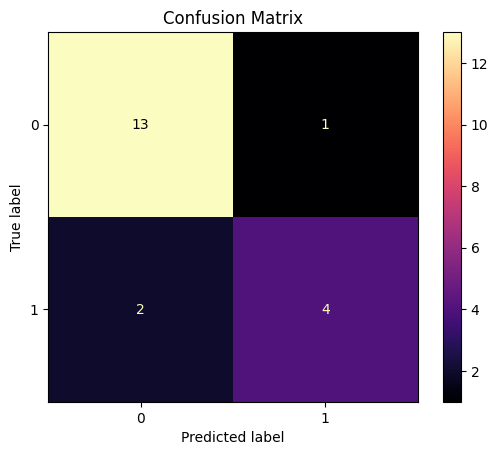

Training completed. Best ROC AUC: 1.0000, Optimal Threshold: 0.5064


In [369]:
epochs = 2
lr = 3e-4

optimizer = th.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = th.nn.BCELoss()

best_threshold, best_score = utils.train_model(
    model, optimizer, criterion, train_loader, valid_loader,
    epochs=10, mean=mean, std=std, patience=3
)

print(f"Training completed. Best ROC AUC: {best_score:.4f}, Optimal Threshold: {best_threshold:.4f}")

In [376]:
def manual_evaluate_test(model, feature, threshold, frame_size=utils.NUM_FRAMES, sampling_rate=utils.SAMPLING_RATE, hop_length=utils.HOP_LENGTH, mean=None, std=None, step_size=None, filter_time_sec=1):
    """
    Manually evaluate the model on an audio feature, returning time positions where gunshots are detected.

    Parameters:
        model: The trained model.
        feature: The feature (e.g., spectrogram) to evaluate.
        threshold: The prediction threshold for gunshots.
        frame_size: Number of frames to use in each evaluation.
        sampling_rate: Audio sampling rate.
        hop_length: Hop length in samples for each frame.
        mean: Mean for normalization.
        std: Standard deviation for normalization.
        step_size: Step size for moving through frames (default: frame_size // 2).
        filter_time_sec: Time (in seconds) to filter out close consecutive predictions.
    
    Returns:
        List of tuples (minutes, seconds, output) where gunshots are detected along with the model's output.
    """
    if mean is None or std is None:
        raise ValueError("Mean and std must be provided for normalization.")

    mean = mean.to(device)
    std = std.to(device)
    model = model.to(device)
    model.eval()

    predictions = []

    feature = feature.to(device)
    feature = (feature - mean) / std

    num_frames = feature.shape[2]

    if step_size is None:
        step_size = 1

    total_iterations = 0

    with th.no_grad():
        for j in range(0, num_frames - frame_size + 1, step_size):
            total_iterations += 1
            start = j
            end = j + frame_size

            input_frame = feature[:, :, start:end].unsqueeze(0).float()
            output = model(input_frame).squeeze().item()
            predictions.append((output, start))

        print("Number of predictions", len(predictions))

        res = []
        for output, start in predictions:
            if output >= threshold:
                time_in_seconds = start * hop_length / sampling_rate
                minutes = int(time_in_seconds // 60)
                seconds = time_in_seconds % 60
                res.append((minutes, seconds, time_in_seconds, output))
                
    print(len(res))
    
    filtered_res = []
    last_detection_time = -float('inf')

    for minutes, seconds, time_in_seconds, output in res:
        if time_in_seconds - last_detection_time >= filter_time_sec:
            filtered_res.append((minutes, seconds, output))
            last_detection_time = time_in_seconds

    return filtered_res

In [377]:
best_threshold

0.5063719

In [378]:
# spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/50 Cent - Many Men (Wish Death) (Dirty Version).mp3'])
spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/M.I.A. - Paper Planes.mp3'])

print(f"Got back spectogram in shape: {spectrograms[0].shape} and sample rate: {sample_rates}")

predictions = manual_evaluate_test(model, spectrograms[0], threshold=best_threshold, mean=mean, std=std, step_size=1, filter_time_sec=1.5)

if(len(predictions) > 0):
    print(f"Current treshold is {best_threshold} \n")

    for minutes, seconds, output in predictions:
        print(f"Detected gunshot at {minutes}m {seconds:.2f}s with model output: {output:.4f}")
else:
    print("No predictions")

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Got back spectogram in shape: torch.Size([3, 80, 17601]) and sample rate: [44100]
Number of predictions 17552
0
No predictions


In [351]:
waveform1, sample1, sr1 = utils.extract_sample_at_time(
    '/PopMusicInformationRetrieval/test_data/50 Cent - Many Men (Wish Death) (Dirty Version).mp3', start_time_sec=2.61)
waveform2, sample2, sr2 = utils.extract_sample_at_time(
    '/PopMusicInformationRetrieval/test_data/50 Cent - Many Men (Wish Death) (Dirty Version).mp3', start_time_sec=5.46)

In [355]:
utils.play_audio(waveform1)

In [354]:
utils.play_audio(waveform2)

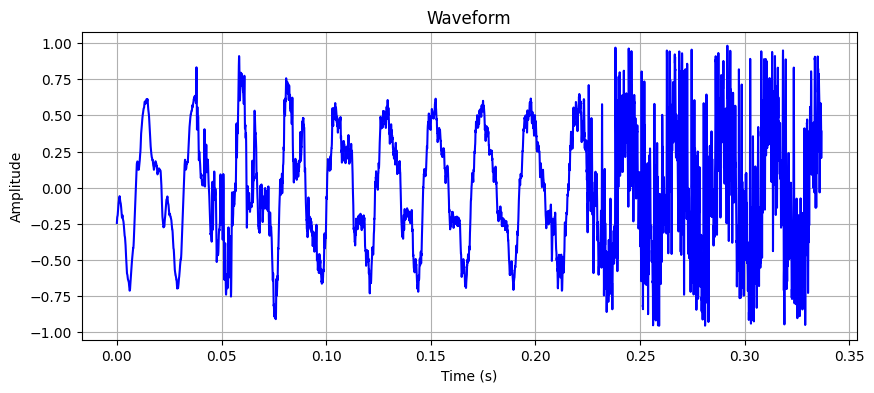

In [356]:
utils.plot_waveform(waveform1)

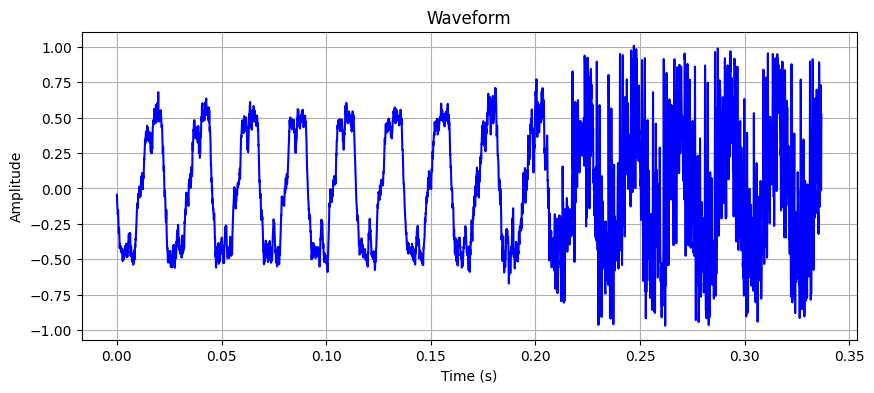

In [357]:
utils.plot_waveform(waveform2)

In [374]:

def process_and_predict(model, audio_path, start_time_sec, mean, std, threshold=best_threshold):
    
    print(f"Treshold {best_threshold}")

    # Extract the waveform and the audio sample
    waveform, sample, sample_rate = utils.extract_sample_at_time(audio_path, start_time_sec)
    
    # utils.plot_waveform(waveform)
    # time.sleep(1)  # Add a small delay to ensure the plot gets time to render

    print(f"Playing the audio sample from {start_time_sec:.2f} seconds.")
    play(sample)

    mean = mean.to(device)
    std = std.to(device)
    model = model.to(device)
    waveform = waveform.to(device)

    mel_spectrogram = utils.calculate_melbands(waveform[0], sample_rate)
    mel_spectrogram = (mel_spectrogram - mean) / std

    # Reshape and feed to model
    with th.no_grad():
        input_tensor = mel_spectrogram.unsqueeze(0).float()
        output = model(input_tensor).squeeze().item()
    
    if output >= threshold:
        prediction = "Gunshot"
    else:
        prediction = "No Gunshot"
    print(f"Model Prediction: {prediction} with output: {output}")
    return prediction

audio_path = 'test_data/M.I.A. - Paper Planes.mp3'
# audio_path = '''./2Pac - Hit 'Em Up (Dirty) (Music Video) HD.mp3'''
# audio_path = './50 Cent - Many Men (Wish Death) (Dirty Version).mp3'

prediction = process_and_predict(model, audio_path, start_time_sec=56, mean=mean, std=std, threshold=best_threshold)

Treshold 0.5063719153404236
Playing the audio sample from 56.00 seconds.


Input #0, wav, from '/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/tmp7uyzrghe.wav':
  Duration: 00:00:00.57, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s



Model Prediction: No Gunshot with output: 0.32946231961250305
